<a href="https://colab.research.google.com/github/jtwang1027/cancer_omics/blob/master/2A_elastic_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_regression

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.decomposition import PCA

In [0]:
au= pd.read_csv('/content/drive/My Drive/hcc1599.csv') # read in data from example cell line

In [0]:
au.dropna(axis=1, inplace=True)
encoded=pd.get_dummies(au.treatment, drop_first=True) #one hot encoding on treatments
au=au.join(encoded)
dropcol= ['cellID', 'fileID', 'cell_line','treatment']
au.drop(  dropcol , axis=1, inplace=True)


X= au.drop(['p.STAT5'], axis=1)
y= au['p.STAT5']

In [0]:
scaler=MinMaxScaler()
sub_col=['time','b.CATENIN', 'cleavedCas', 'CyclinB', 'GAPDH', 'IdU', 'Ki.67',
       'p.4EBP1', 'p.Akt.Ser473.', 'p.AKT.Thr308.', 'p.AMPK', 'p.BTK',
       'p.CREB', 'p.ERK', 'p.FAK', 'p.GSK3b', 'p.H3', 'p.HER2', 'p.JNK',
       'p.MAP2K3', 'p.MAPKAPK2', 'p.MEK', 'p.MKK3.MKK6', 'p.MKK4', 'p.NFkB',
       'p.p38', 'p.p53', 'p.p90RSK', 'p.PDPK1', 'p.PLCg2', 'p.RB', 'p.S6',
       'p.S6K', 'p.SMAD23', 'p.SRC', 'p.STAT1', 'p.STAT3']

In [0]:
X[sub_col]=scaler.fit_transform(X[sub_col])

In [41]:
X.describe()

,time,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,p.Akt.Ser473.,p.AKT.Thr308.,p.AMPK,p.BTK,p.CREB,p.ERK,p.FAK,p.GSK3b,p.H3,p.HER2,p.JNK,p.MAP2K3,p.MAPKAPK2,p.MEK,p.MKK3.MKK6,p.MKK4,p.NFkB,p.p38,p.p53,p.p90RSK,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,full,iEGFR,iMEK,iPI3K,iPKC
count,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,8.387500e+04,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000,83875.000000
mean,0.289226,0.165119,0.356437,0.107860,0.358082,0.141313,0.233835,0.236990,0.245015,0.188238,0.353340,0.308806,8.900056e-02,0.276090,0.152567,0.226012,0.198381,0.362181,0.183216,0.287818,0.201194,0.184079,0.356680,0.264590,0.515334,0.201270,0.146950,0.212492,0.178170,0.212959,0.157249,0.209683,0.100522,0.152788,0.153935,0.417881,0.135398,0.025335,0.163875,0.183452,0.169884,0.202301
std,0.319890,0.129427,0.307586,0.131694,0.218360,0.165401,0.214887,0.225477,0.193687,0.178627,0.122770,0.153995,8.323356e-02,0.204045,0.124466,0.237190,0.133245,0.179421,0.180408,0.212314,0.173417,0.128609,0.197302,0.168319,0.201496,0.156179,0.131121,0.207077,0.155175,0.183776,0.176455,0.195732,0.109621,0.143418,0.120056,0.184403,0.132339,0.157142,0.370164,0.387039,0.375533,0.401718
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.045105,0.044239,0.000000,0.189382,0.000000,0.004620,0.000000,0.073002,0.000000,0.282014,0.209751,5.647363e-07,0.103234,0.026815,0.000000,0.096054,0.241747,0.000000,0.094369,0.000000,0.068570,0.218477,0.141737,0.364974,0.055654,0.025127,0.000000,0.009025,0.027737,0.000000,0.036441,0.000000,0.000000,0.037076,0.301143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.150000,0.158055,0.314350,0.059135,0.370675,0.115100,0.195693,0.198929,0.213871,0.161327,0.361756,0.314915,7.740761e-02,0.264429,0.145819,0.151054,0.199472,0.378448,0.150189,0.289169,0.200963,0.192022,0.375464,0.264965,0.572675,0.194002,0.131239,0.171571,0.164283,0.191607,0.101071,0.171326,0.064588,0.132622,0.150680,0.446954,0.113689,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.262007,0.591649,0.177865,0.526949,0.197116,0.397917,0.413589,0.413427,0.322035,0.435337,0.411193,1.529911e-01,0.422391,0.247338,0.421739,0.289876,0.494419,0.300328,0.450356,0.352333,0.286264,0.503044,0.375977,0.676309,0.320973,0.226648,0.345870,0.292527,0.349631,0.254631,0.321703,0.184785,0.262647,0.250350,0.555764,0.228625,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state=1234)

In [0]:
# X_train, y_test = make_regression(n_features= len(X_train.columns), random_state=0)

In [0]:
elastic= ElasticNet(random_state=0, normalize=True)
#grid search 
search=GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=-1,refit=True,cv=10)


In [44]:
search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=0, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'l1_ratio': [0.2, 0.4, 0.6, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [45]:
pred=search.predict(X_test)
sqrt(mean_squared_error(pred,y_test)) #elastic net RMSE

0.618181277585146

Does adding PCA components as features improve linear model performance?

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:

pca=PCA(n_components=10)
reduced=pca.fit_transform(X)

Text(0.5, 1.0, 'Explained variance from PCA')

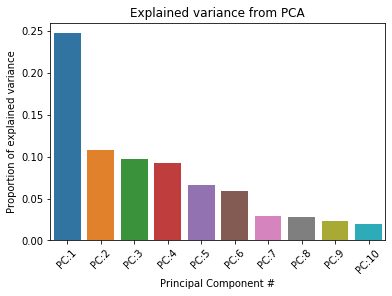

In [104]:
g=sns.barplot(x= ["PC:" + str(w+1) for w in range(len(pca.explained_variance_ratio_))] ,y=pca.explained_variance_ratio_)
plt.xticks(rotation=45)
plt.xlabel('Principal Component #')
plt.ylabel('Proportion of explained variance')
plt.title('Explained variance from PCA')

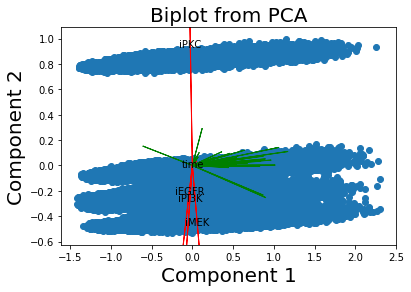

In [106]:
scale=4
plt.scatter( reduced[:,0],reduced[:,1])
plt.xlabel('Component 1',fontsize=20)
plt.ylabel('Component 2',fontsize=20)
plt.title("Biplot from PCA",fontsize=20)
for i in range(pca.components_.shape[1]):
  x_arrow= pca.components_[0,i]*scale
  y_arrow= pca.components_[1,i]*scale

  if X_train.columns[i] in ['iPKC','iEGFR','iMEK','iPI3K','time']:
    plt.arrow(0,0,x_arrow,y_arrow,color='r')
    plt.text(x_arrow* 0.28, y_arrow * 0.28, X_train.columns[i], color = 'k', ha = 'center', va = 'center')    
  else:
    plt.arrow(0,0,x_arrow,y_arrow,color='g')
#     plt.text(x_arrow* 1, y_arrow * 1, X_train.columns[i], color = 'k', ha = 'center', va = 'center')

green= protein columns
red= treatment-based columns

Interestingly, from this PCA plot we can see that the second principal component is largely determined by the treatment conditions. iPKC treatment results in a significantly different type of pSTAT5 response relative to iEGFR, iPI3K, and iMEK.

In [59]:
#add first 6 principal components as features
xpca=pd.DataFrame(reduced[:,:6], columns=['pc' + str(i) for i in range(1,7)])
xpca.head()

,pc1,pc2,pc3,pc4,pc5,pc6
0,0.143827,0.004802,-0.017752,-0.066686,0.238434,-0.373795
1,-0.008057,-0.063852,-0.066726,-0.005774,-0.277385,-0.441611
2,0.319928,-0.044904,-0.076755,0.017817,-0.282883,-0.334134
3,-0.777144,-0.091419,-0.008367,0.013000,-0.237579,-0.304584
4,0.167290,0.022954,-0.000483,-0.079786,0.326273,-0.377021


In [0]:
#from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X2,y,test_size = 0.25, random_state=1234)

In [0]:
elastic= ElasticNet(random_state=0, normalize=True)
search=GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)


In [63]:
search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=0, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=1,
             param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'l1_ratio': [0.2, 0.4, 0.6, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [64]:
pred=search.predict(X_test)
sqrt(mean_squared_error(pred,y_test))

0.6182330214809026

Comparing the RMSE of models, adding principal components as features did not improve RMSE on predictions